In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold, SelectFromModel, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import shap
import random
import optuna
import optuna.logging
import warnings
import multiprocessing
import json
import os
import optuna.exceptions
import concurrent.futures
import itertools
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.INFO)

/Users/hangvu/miniforge3/envs/mod4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Optimize multiprocessing settings
os.environ['LOKY_MAX_CPU_COUNT'] = str(multiprocessing.cpu_count())
os.environ['NUMBA_NUM_THREADS'] = '1'  # Prevent nested parallelism conflicts
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

print(f"Using {multiprocessing.cpu_count()} CPU cores for parallel processing")

Using 8 CPU cores for parallel processing


In [3]:
# Load UCI Heart Disease Cleveland dataset only
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, names=columns, na_values='?')

# Display shape and head
print(f'Dataset shape: {df.shape}')
df.head()

# Data info and description
df.info()
df.describe()

Dataset shape: (303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


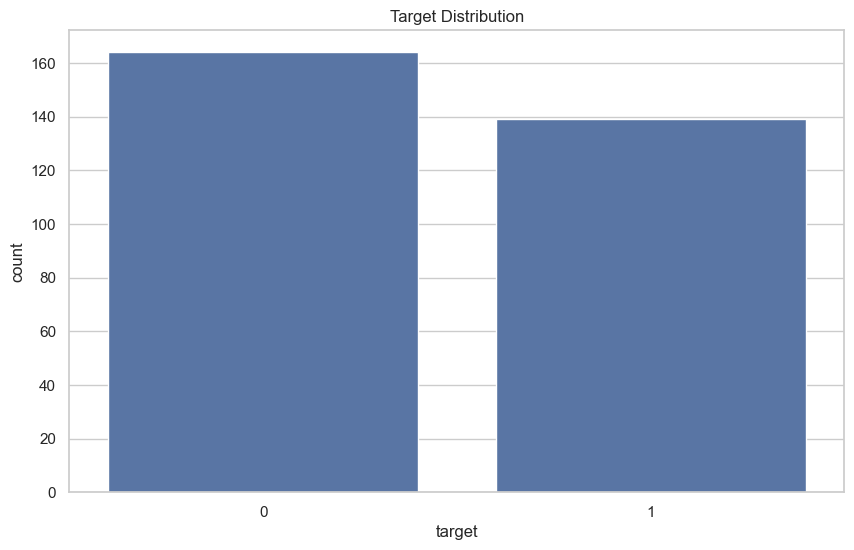

target
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [4]:
# Binarize target and visualize
df['target'] = np.where(df['num'] > 0, 1, 0)
df.drop('num', axis=1, inplace=True)

sns.countplot(x='target', data=df)
plt.title('Target Distribution')
plt.show()

print(df['target'].value_counts(normalize=True))

In [5]:
# Train-test split (imputation and other preprocessing will be handled inside CV and on full train/test)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Define numerical and categorical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [7]:
# Imputer as a class returning DataFrame
class DFImputer:
    def __init__(self):
        self.imputer = ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='median'), numerical_features),
                ('cat', SimpleImputer(strategy='most_frequent'), categorical_features)
            ],
            remainder='passthrough'
        )
        self.columns = numerical_features + categorical_features

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X):
        arr = self.imputer.transform(X)
        return pd.DataFrame(arr, columns=self.columns, index=X.index)

In [8]:
# Feature Engineering Classes (modified to return only df in transform, num/cat as attributes)
class BasicFE:
    def fit(self, df, y=None):
        self.num_features = numerical_features.copy()
        self.cat_features = categorical_features.copy()
        return self
    
    def transform(self, df):
        return df.copy()

class PolyFE:
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, include_bias=False)
    
    def fit(self, df, y=None):
        self.poly.fit(df[numerical_features])
        self.num_features = list(self.poly.get_feature_names_out(numerical_features))
        self.cat_features = categorical_features.copy()
        return self
    
    def transform(self, df):
        df_t = df.copy()
        poly_df = pd.DataFrame(self.poly.transform(df_t[numerical_features]), columns=self.num_features, index=df_t.index)
        df_t = pd.concat([df_t.drop(numerical_features, axis=1), poly_df], axis=1)
        return df_t

class EnhancedFE:
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        self.pt = PowerTransformer(method='yeo-johnson')
    
    def fit(self, df, y=None):
        df_temp = self.add_manual_features(df.copy())
        num_for_poly = numerical_features + ['age_chol', 'oldpeak_slope', 'thalach_exang', 'cp_oldpeak']
        self.poly.fit(df_temp[num_for_poly])
        poly_names = self.poly.get_feature_names_out(num_for_poly)
        poly_df = pd.DataFrame(self.poly.transform(df_temp[num_for_poly]), columns=poly_names, index=df.index)
        self.pt.fit(poly_df)
        self.num_features = list(poly_names)
        self.cat_features = categorical_features + ['age_bin', 'chol_bin', 'trestbps_bin']
        return self
    
    def transform(self, df):
        df_t = self.add_manual_features(df.copy())
        num_for_poly = numerical_features + ['age_chol', 'oldpeak_slope', 'thalach_exang', 'cp_oldpeak']
        poly_df = pd.DataFrame(self.poly.transform(df_t[num_for_poly]), columns=self.poly.get_feature_names_out(num_for_poly), index=df.index)
        poly_pt = pd.DataFrame(self.pt.transform(poly_df), columns=self.poly.get_feature_names_out(num_for_poly), index=df.index)
        df_t = pd.concat([df_t.drop(num_for_poly, axis=1), poly_pt], axis=1)
        return df_t
    
    def add_manual_features(self, df):
        df = df.copy()
        df['age_bin'] = pd.cut(df['age'], bins=[0, 40, 50, 60, 70, 100], labels=[0,1,2,3,4]).astype(float)
        df['chol_bin'] = pd.cut(df['chol'], bins=[0, 200, 240, 300, 1000], labels=[0,1,2,3]).astype(float)
        df['trestbps_bin'] = pd.cut(df['trestbps'], bins=[0, 120, 140, 160, 200], labels=[0,1,2,3]).astype(float)
        df['age_chol'] = df['age'] * df['chol']
        df['oldpeak_slope'] = df['oldpeak'] * df['slope']
        df['thalach_exang'] = df['thalach'] * df['exang']
        df['cp_oldpeak'] = df['cp'] * df['oldpeak']
        return df

fe_options = {
    'basic': BasicFE(),
    'enhanced': EnhancedFE(),
    'poly_only': PolyFE()
}

In [9]:
# Scaler Options
scaler_options = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}

In [10]:
# Feature Selection Options
class VarianceSelector:
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.selector = VarianceThreshold(threshold=self.threshold)

    def fit(self, X, y=None):
        self.selector.fit(X)
        return self

    def transform(self, X):
        return X[:, self.selector.get_support()]

    def get_support(self):
        return self.selector.get_support()

def fs_variance(X_pre, y, threshold=0.01):
    selector = VarianceSelector(threshold=threshold)
    selector.fit(X_pre)
    return selector.transform(X_pre), np.where(selector.get_support())[0]

# For correlation, no y needed
def fs_correlation(X_pre, y, corr_threshold=0.9):
    if hasattr(X_pre, 'toarray'):
        X_pre = X_pre.toarray()
    df_pre = pd.DataFrame(X_pre)
    df_pre.columns = [f'feat_{i}' for i in range(X_pre.shape[1])]
    corr = df_pre.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    keep = [col for col in df_pre.columns if col not in to_drop]
    indices = np.array([int(col.split('_')[1]) for col in keep])
    return df_pre[keep].values, indices

class KBestFSelector:
    def __init__(self, k=0.8):
        self.k = k

    def fit(self, X, y):
        k = self.k if isinstance(self.k, int) else int(X.shape[1] * self.k)
        self.selector = SelectKBest(f_classif, k=k)
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return self.selector.transform(X)

    def get_support(self):
        return self.selector.get_support()

def fs_kbest_f(X_pre, y, k=0.8):
    selector = KBestFSelector(k=k)
    selector.fit(X_pre, y)
    return selector.transform(X_pre), np.where(selector.get_support())[0]

class KBestMISelector:
    def __init__(self, k=0.8):
        self.k = k

    def fit(self, X, y):
        k = self.k if isinstance(self.k, int) else int(X.shape[1] * self.k)
        self.selector = SelectKBest(mutual_info_classif, k=k)
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return self.selector.transform(X)

    def get_support(self):
        return self.selector.get_support()

def fs_kbest_mi(X_pre, y, k=0.8):
    selector = KBestMISelector(k=k)
    selector.fit(X_pre, y)
    return selector.transform(X_pre), np.where(selector.get_support())[0]

def fs_rfe_svm(X_pre, y):
    model = SVC(kernel='linear')
    selector = RFECV(estimator=model, step=0.2, min_features_to_select=1, cv=3)
    selector.fit(X_pre, y)
    return X_pre[:, selector.support_], np.where(selector.support_)[0]

def fs_select_model_lr(X_pre, y):
    model = LogisticRegression(random_state=42, max_iter=500, solver='liblinear')
    selector = SelectFromModel(model, threshold='median')
    selector.fit(X_pre, y)
    return X_pre[:, selector.get_support()], np.where(selector.get_support())[0]

def fs_rfe_lr(X_pre, y):
    model = LogisticRegression(random_state=42, max_iter=500)
    selector = RFECV(estimator=model, step=0.2, min_features_to_select=1, cv=3)
    selector.fit(X_pre, y)
    return X_pre[:, selector.support_], np.where(selector.support_)[0]

def fs_boruta(X_pre, y, max_iter=50, alpha=0.05):
    if hasattr(X_pre, 'toarray'):
        X_pre = X_pre.toarray()
    X = pd.DataFrame(X_pre)
    X.columns = [f'feat_{i}' for i in range(X.shape[1])]
    num_feat = X.shape[1]
    hits = np.zeros(num_feat)
    for iter_ in range(max_iter):
        shadow = X.apply(np.random.permutation)
        shadow.columns = [f'shadow_{i}' for i in range(num_feat)]
        X_boruta = pd.concat([X, shadow], axis=1)
        rf = RandomForestClassifier(n_jobs=1, max_depth=None, random_state=42)
        rf.fit(X_boruta, y)
        feat_imp_X = rf.feature_importances_[:num_feat]
        feat_imp_shadow = rf.feature_importances_[num_feat:]
        hits += (feat_imp_X > feat_imp_shadow.max())
    criteria = hits / max_iter > 1 - alpha
    return X_pre[:, criteria], np.where(criteria)[0]

fs_options = {
    'variance': fs_variance,
    'correlation': fs_correlation,
    'kbest_f': fs_kbest_f,
    'kbest_mi': fs_kbest_mi,
    'rfe_svm': fs_rfe_svm,
    'select_lr': fs_select_model_lr,
    'rfe_lr': fs_rfe_lr,
    'boruta': fs_boruta
}

In [11]:
# Model Options
models = {
    'dt': DecisionTreeClassifier,
    'knn': KNeighborsClassifier,
    'rf': RandomForestClassifier,
    'ada': AdaBoostClassifier,
    'gb': GradientBoostingClassifier,
    'xgb': XGBClassifier,
    'lgbm': LGBMClassifier,
    'svm': SVC,
    'lr': LogisticRegression
}

# Ensemble (Soft Voting) - will be tuned separately
def get_ensemble(rf_model, xgb_model, lgbm_model, weights):
    estimators = [
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ]
    return VotingClassifier(estimators=estimators, voting='soft', weights=weights, n_jobs=1)


In [12]:
# Configuration: Choose optimization metric for hyperparameter tuning
OPTIMIZATION_METRIC = 'roc_auc'

# Available metrics for optimization
optimization_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='binary'),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

print(f"Hyperparameter tuning will optimize for: {OPTIMIZATION_METRIC.upper()}")
print(f"Available metrics: {list(optimization_metrics.keys())}")

# Get the scorer for the selected metric
selected_scorer = optimization_metrics[OPTIMIZATION_METRIC]

def _ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=True)

Hyperparameter tuning will optimize for: ROC_AUC
Available metrics: ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']


In [13]:
results = []
best_models = {}
combo_results = {}  # New dict to store results by combo_str
total_combos = len(fe_options) * len(scaler_options) * len(fs_options) * len(models)

print(f"Starting hyperparameter optimization based on {OPTIMIZATION_METRIC.upper()} metric...")
print(f"Total combinations to evaluate: {total_combos}")

def tune_model(model_name, fe_name, scaler_name, fs_name, fe_transformer, folds_fs):
    combo_str = f'{fe_name}-{scaler_name}-{fs_name}-{model_name}'
    
    # Suppress individual Optuna study outputs for speed
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    try:
        scorer = selected_scorer
        
        model_class = models[model_name]
        
        def obj(trial):
            if model_name == 'dt':
                params = {
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
                    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
                    'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
                }
            elif model_name == 'knn':
                params = {
                    'n_neighbors': trial.suggest_int('n_neighbors', 3, 9),
                    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
                    'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
                }
            elif model_name == 'rf':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_categorical('max_depth', [None] + list(range(3, 15))),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 15)
                }
            elif model_name == 'ada':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 10, 150),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
                }
            elif model_name == 'gb':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 100),
                    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),
                    'max_depth': trial.suggest_int('max_depth', 3, 6),
                    'subsample': trial.suggest_float('subsample', 0.8, 1.0),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
                }
            elif model_name == 'xgb':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 400),
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0)
                }
            elif model_name == 'lgbm':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 100, 400), 
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                    'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                    'reg_alpha': trial.suggest_float('reg_alpha', 0, 3), 
                    'reg_lambda': trial.suggest_float('reg_lambda', 0, 3),  
                    'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
                    'num_leaves': trial.suggest_int('num_leaves', 15, 80), 
                    'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
                }
            elif model_name == 'svm':
                kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
                C = trial.suggest_float('C', 0.1, 10, log=True)  
                class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
                if kernel == 'rbf':
                    gamma = trial.suggest_float('gamma', 1e-3, 1, log=True) 
                    params = {'kernel': kernel, 'C': C, 'gamma': gamma, 'class_weight': class_weight}
                else:
                    params = {'kernel': kernel, 'C': C, 'class_weight': class_weight}
            elif model_name == 'lr':
                params = {
                    'C': trial.suggest_float('C', 0.01, 5, log=True),  
                    'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
                    'penalty': 'l2',
                    'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
                    'max_iter': 300
                }
            
            extra_kwargs = {}
            if model_name in ['dt', 'rf', 'ada', 'gb', 'xgb', 'lgbm', 'lr']:
                extra_kwargs['random_state'] = 42
            if model_name == 'svm':
                extra_kwargs['probability'] = False
            if model_name == 'lgbm':
                extra_kwargs['verbose'] = -1
            if model_name == 'xgb':
                extra_kwargs['eval_metric'] = 'logloss'
            if model_name in ['rf', 'xgb', 'lgbm', 'knn', 'lr']:
                extra_kwargs['n_jobs'] = 1
            
            mod = model_class(**params, **extra_kwargs)
            
            cv_scores = []
            for fold_idx, fold_data in enumerate(folds_fs):
                X_train_fs = fold_data['X_train_fs']
                y_train = fold_data['y_train']
                X_val_fs = fold_data['X_val_fs']
                y_val = fold_data['y_val']
                
                if model_name in ['knn', 'svm']:
                    if hasattr(X_train_fs, 'toarray'):
                        X_train_fs = X_train_fs.toarray()
                    if hasattr(X_val_fs, 'toarray'):
                        X_val_fs = X_val_fs.toarray()
                
                mod.fit(X_train_fs, y_train)
                
                if OPTIMIZATION_METRIC == 'roc_auc':
                    if hasattr(mod, 'decision_function'):
                        y_val_pred = mod.decision_function(X_val_fs)
                    else:
                        y_val_pred = mod.predict_proba(X_val_fs)[:, 1]
                else:
                    y_val_pred = mod.predict(X_val_fs)
                
                score = scorer._score_func(y_val, y_val_pred)
                cv_scores.append(score)
                
                # Report intermediate score for pruning
                current_mean = np.mean(cv_scores)
                trial.report(current_mean, fold_idx + 1)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
            
            return np.mean(cv_scores)
        
        if model_name in ['rf', 'xgb', 'lgbm']:
            n_trials = 50
        elif model_name in ['gb', 'svm']:
            n_trials = 50
        else:
            n_trials = 50
        
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=3), pruner=optuna.pruners.MedianPruner())
        study.optimize(obj, n_trials=n_trials, show_progress_bar=False)
        best_params = study.best_params
        
        return {
            'combo': combo_str,
            'cv_optimization_score': study.best_value,
            'best_params': best_params,
            'model_name': model_name,
            'model_class': model_class,
            'fe_transformer': fe_transformer,
            'scaler_name': scaler_name,
            'fs_name': fs_name
        }
    
    except Exception as e:
        print(f"Error in combo {combo_str}: {str(e)}")
        return {
            'combo': combo_str,
            'cv_optimization_score': 0.0,
            'best_params': {},
            'model_name': model_name,
            'error': str(e)
        }

def _run_tune(args):
    m, data = args
    return tune_model(m, *data)

with tqdm(total=total_combos, desc="EP", ncols=100, mininterval=1.0) as pbar:
    for fe_name in fe_options:
        fe_transformer = fe_options[fe_name]
        for scaler_name in scaler_options:
            # Precompute preprocessed folds for this FE and scaler
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            folds_pre = []
            # Precompute full for OHE categories
            pre_pipe_full = Pipeline([
                ('imputer', DFImputer()),
                ('fe', fe_transformer)
            ])
            X_train_fe_full = pre_pipe_full.fit_transform(X_train)
            num_fe = pre_pipe_full.named_steps['fe'].num_features
            cat_fe = pre_pipe_full.named_steps['fe'].cat_features

            # Freeze categories from OUTER TRAIN ONLY
            ohe_cats = _ohe().fit(X_train_fe_full[cat_fe]).categories_
            
            for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
                X_fold_train_orig = X_train.iloc[train_idx].copy()
                y_fold_train = y_train.iloc[train_idx]
                X_fold_val_orig = X_train.iloc[val_idx].copy()
                y_fold_val = y_train.iloc[val_idx]
                
                # Master pre-pipe: imputer + fe
                pre_pipe = Pipeline([
                    ('imputer', DFImputer()),
                    ('fe', fe_transformer)
                ])
                X_fold_train_fe = pre_pipe.fit_transform(X_fold_train_orig)
                X_fold_val_fe = pre_pipe.transform(X_fold_val_orig)
                
                # Preprocessing with fixed categories
                preprocessor_fold = ColumnTransformer(
                    transformers=[
                        ('num', scaler_options[scaler_name], num_fe),
                        ('cat', OneHotEncoder(categories=ohe_cats, handle_unknown='ignore', sparse_output=True), cat_fe)
                    ]
                )
                X_fold_train_pre = preprocessor_fold.fit_transform(X_fold_train_fe)
                X_fold_val_pre = preprocessor_fold.transform(X_fold_val_fe)
                
                folds_pre.append({
                    'X_train_pre': X_fold_train_pre,
                    'X_val_pre': X_fold_val_pre,
                    'y_train': y_fold_train,
                    'y_val': y_fold_val
                })
            
            # Now for each FS
            for fs_name in fs_options:
                # Precompute FS for this combo
                folds_fs_list = []
                for fold in folds_pre:
                    X_train_fs, support_fold = fs_options[fs_name](fold['X_train_pre'], fold['y_train'])
                    X_val_fs = fold['X_val_pre'][:, support_fold]
                    folds_fs_list.append({
                        'X_train_fs': X_train_fs,
                        'X_val_fs': X_val_fs,
                        'y_train': fold['y_train'],
                        'y_val': fold['y_val']
                    })
                
                # Now parallelize over models
                model_names = list(models.keys())
                combo_data = (fe_name, scaler_name, fs_name, fe_transformer, folds_fs_list)
                
                with concurrent.futures.ThreadPoolExecutor(max_workers=len(model_names)) as executor:
                    model_results = list(executor.map(_run_tune, [(m, combo_data) for m in model_names]))
                
                for result in model_results:
                    if 'error' not in result:
                        results.append(result)
                        combo_results[result['combo']] = result
                        
                        optimization_score = result['cv_optimization_score']
                        
                        mname = result['model_name']
                        if mname not in best_models or optimization_score > best_models.get(mname, {}).get('cv_optimization_score', 0):
                            best_models[mname] = result
                        
                        pbar.set_postfix({
                            'Current': f"{mname}",
                            'Best Score': f"{optimization_score:.3f}",
                            'Overall Best': f"{max(r['cv_optimization_score'] for r in results):.3f}"
                        })
                    pbar.update(1)

print(f"\nCompleted optimization using {OPTIMIZATION_METRIC.upper()} as the target metric.")
print(f"Processed {len(results)} combinations successfully.")
if results:
    print(f"Best overall score: {max(r['cv_optimization_score'] for r in results):.4f}")
else:
    print("No results obtained - check for errors above.")

# Select best combo based on CV
best_optimization_score = max(r['cv_optimization_score'] for r in results)
best_res = max(results, key=lambda r: r['cv_optimization_score'])
best_combo = best_res['combo']
print(f'\nBest combination (optimized for {OPTIMIZATION_METRIC.upper()}): {best_combo}')
print(f'Best CV {OPTIMIZATION_METRIC.upper()}: {best_optimization_score:.4f}')

Starting hyperparameter optimization based on ROC_AUC metric...
Total combinations to evaluate: 648


EP: 100%|███████| 648/648 [44:14<00:00,  4.10s/it, Current=lr, Best Score=0.899, Overall Best=0.919]


Completed optimization using ROC_AUC as the target metric.
Processed 648 combinations successfully.
Best overall score: 0.9185

Best combination (optimized for ROC_AUC): basic-standard-kbest_mi-knn
Best CV ROC_AUC: 0.9185


In [14]:
# Find best for rf, xgb, lgbm
best_rf = max([r for r in results if r['model_name'] == 'rf'], key=lambda r: r['cv_optimization_score'], default=None)
best_xgb = max([r for r in results if r['model_name'] == 'xgb'], key=lambda r: r['cv_optimization_score'], default=None)
best_lgbm = max([r for r in results if r['model_name'] == 'lgbm'], key=lambda r: r['cv_optimization_score'], default=None)

if best_rf and best_xgb and best_lgbm:
    print("\nTuning Ensemble...")
    
    # Note: Ensemble uses the best individual pipelines, but for simplicity, we'll assume they share similar preprocessing or refit them
    # In practice, since different combos may have different FE/FS, we need to refit each base model with its best config
    
    def ensemble_obj(trial):
        w_rf = trial.suggest_float('w_rf', 0.0, 1.0)
        w_xgb = trial.suggest_float('w_xgb', 0.0, 1.0)
        w_lgbm = trial.suggest_float('w_lgbm', 0.0, 1.0)
        weights = [w_rf, w_xgb, w_lgbm]
        
        # Normalize weights
        total = sum(weights)
        if total == 0:
            return 0
        weights = [w / total for w in weights]
        
        cv_scores = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            y_fold_val = y_train.iloc[val_idx]
            
            # Refit each base model with its best config on fold
            # For rf
            rf_fe = best_rf['fe_transformer']
            rf_scaler = scaler_options[best_rf['scaler_name']]
            rf_fs = fs_options[best_rf['fs_name']]
            rf_params = best_rf['best_params']
            rf_model = RandomForestClassifier(**rf_params, random_state=42, n_jobs=1)
            
            pre_pipe_rf = Pipeline([('imputer', DFImputer()), ('fe', rf_fe)])
            X_fold_train_rf_fe = pre_pipe_rf.fit_transform(X_fold_train)
            X_fold_val_rf_fe = pre_pipe_rf.transform(X_fold_val)
            num_fe_rf = pre_pipe_rf.named_steps['fe'].num_features
            cat_fe_rf = pre_pipe_rf.named_steps['fe'].cat_features
            preprocessor_rf = ColumnTransformer([
                ('num', rf_scaler, num_fe_rf),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_fe_rf)
            ])
            X_fold_train_rf_pre = preprocessor_rf.fit_transform(X_fold_train_rf_fe)
            X_fold_val_rf_pre = preprocessor_rf.transform(X_fold_val_rf_fe)
            X_fold_train_rf_fs, support_rf = rf_fs(X_fold_train_rf_pre, y_fold_train)
            X_fold_val_rf_fs = X_fold_val_rf_pre[:, support_rf]
            rf_model.fit(X_fold_train_rf_fs, y_fold_train)
            
            # For xgb
            xgb_fe = best_xgb['fe_transformer']
            xgb_scaler = scaler_options[best_xgb['scaler_name']]
            xgb_fs = fs_options[best_xgb['fs_name']]
            xgb_params = best_xgb['best_params']
            xgb_model = XGBClassifier(**xgb_params, random_state=42, n_jobs=1, eval_metric='logloss')
            
            pre_pipe_xgb = Pipeline([('imputer', DFImputer()), ('fe', xgb_fe)])
            X_fold_train_xgb_fe = pre_pipe_xgb.fit_transform(X_fold_train)
            X_fold_val_xgb_fe = pre_pipe_xgb.transform(X_fold_val)
            num_fe_xgb = pre_pipe_xgb.named_steps['fe'].num_features
            cat_fe_xgb = pre_pipe_xgb.named_steps['fe'].cat_features
            preprocessor_xgb = ColumnTransformer([
                ('num', xgb_scaler, num_fe_xgb),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_fe_xgb)
            ])
            X_fold_train_xgb_pre = preprocessor_xgb.fit_transform(X_fold_train_xgb_fe)
            X_fold_val_xgb_pre = preprocessor_xgb.transform(X_fold_val_xgb_fe)
            X_fold_train_xgb_fs, support_xgb = xgb_fs(X_fold_train_xgb_pre, y_fold_train)
            X_fold_val_xgb_fs = X_fold_val_xgb_pre[:, support_xgb]
            xgb_model.fit(X_fold_train_xgb_fs, y_fold_train)
            
            # For lgbm
            lgbm_fe = best_lgbm['fe_transformer']
            lgbm_scaler = scaler_options[best_lgbm['scaler_name']]
            lgbm_fs = fs_options[best_lgbm['fs_name']]
            lgbm_params = best_lgbm['best_params']
            lgbm_model = LGBMClassifier(**lgbm_params, random_state=42, n_jobs=1, verbose=-1)
            
            pre_pipe_lgbm = Pipeline([('imputer', DFImputer()), ('fe', lgbm_fe)])
            X_fold_train_lgbm_fe = pre_pipe_lgbm.fit_transform(X_fold_train)
            X_fold_val_lgbm_fe = pre_pipe_lgbm.transform(X_fold_val)
            num_fe_lgbm = pre_pipe_lgbm.named_steps['fe'].num_features
            cat_fe_lgbm = pre_pipe_lgbm.named_steps['fe'].cat_features
            preprocessor_lgbm = ColumnTransformer([
                ('num', lgbm_scaler, num_fe_lgbm),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_fe_lgbm)
            ])
            X_fold_train_lgbm_pre = preprocessor_lgbm.fit_transform(X_fold_train_lgbm_fe)
            X_fold_val_lgbm_pre = preprocessor_lgbm.transform(X_fold_val_lgbm_fe)
            X_fold_train_lgbm_fs, support_lgbm = lgbm_fs(X_fold_train_lgbm_pre, y_fold_train)
            X_fold_val_lgbm_fs = X_fold_val_lgbm_pre[:, support_lgbm]
            lgbm_model.fit(X_fold_train_lgbm_fs, y_fold_train)
            
            # Predict proba from each base on its own val_fs, then average with weights
            rf_proba = rf_model.predict_proba(X_fold_val_rf_fs)[:, 1]
            xgb_proba = xgb_model.predict_proba(X_fold_val_xgb_fs)[:, 1]
            lgbm_proba = lgbm_model.predict_proba(X_fold_val_lgbm_fs)[:, 1]
            y_val_pred = weights[0] * rf_proba + weights[1] * xgb_proba + weights[2] * lgbm_proba
            
            score = roc_auc_score(y_fold_val, y_val_pred)
            cv_scores.append(score)
        
        return np.mean(cv_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(ensemble_obj, n_trials=50)
    best_weights = [study.best_params['w_rf'], study.best_params['w_xgb'], study.best_params['w_lgbm']]
    
    # Normalize
    total = sum(best_weights)
    best_weights = [w / total for w in best_weights]
    
    print(f"Best ensemble weights: {best_weights}")
    
    # Refit bases on full train with best configs
    # For rf
    pre_pipe_rf = Pipeline([('imputer', DFImputer()), ('fe', best_rf['fe_transformer'])])
    X_train_rf_fe = pre_pipe_rf.fit_transform(X_train)
    X_test_rf_fe = pre_pipe_rf.transform(X_test)
    num_fe_rf = pre_pipe_rf.named_steps['fe'].num_features
    cat_fe_rf = pre_pipe_rf.named_steps['fe'].cat_features
    preprocessor_rf = ColumnTransformer([
        ('num', scaler_options[best_rf['scaler_name']], num_fe_rf),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_fe_rf)
    ])
    X_train_rf_pre = preprocessor_rf.fit_transform(X_train_rf_fe)
    X_test_rf_pre = preprocessor_rf.transform(X_test_rf_fe)
    X_train_rf_fs, support_rf = fs_options[best_rf['fs_name']](X_train_rf_pre, y_train)
    X_test_rf_fs = X_test_rf_pre[:, support_rf]
    rf_model = RandomForestClassifier(**best_rf['best_params'], random_state=42, n_jobs=1)
    rf_model.fit(X_train_rf_fs, y_train)
    
    # For xgb
    pre_pipe_xgb = Pipeline([('imputer', DFImputer()), ('fe', best_xgb['fe_transformer'])])
    X_train_xgb_fe = pre_pipe_xgb.fit_transform(X_train)
    X_test_xgb_fe = pre_pipe_xgb.transform(X_test)
    num_fe_xgb = pre_pipe_xgb.named_steps['fe'].num_features
    cat_fe_xgb = pre_pipe_xgb.named_steps['fe'].cat_features
    preprocessor_xgb = ColumnTransformer([
        ('num', scaler_options[best_xgb['scaler_name']], num_fe_xgb),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_fe_xgb)
    ])
    X_train_xgb_pre = preprocessor_xgb.fit_transform(X_train_xgb_fe)
    X_test_xgb_pre = preprocessor_xgb.transform(X_test_xgb_fe)
    X_train_xgb_fs, support_xgb = fs_options[best_xgb['fs_name']](X_train_xgb_pre, y_train)
    X_test_xgb_fs = X_test_xgb_pre[:, support_xgb]
    xgb_model = XGBClassifier(**best_xgb['best_params'], random_state=42, n_jobs=1, eval_metric='logloss')
    xgb_model.fit(X_train_xgb_fs, y_train)
    
    # For lgbm
    pre_pipe_lgbm = Pipeline([('imputer', DFImputer()), ('fe', best_lgbm['fe_transformer'])])
    X_train_lgbm_fe = pre_pipe_lgbm.fit_transform(X_train)
    X_test_lgbm_fe = pre_pipe_lgbm.transform(X_test)
    num_fe_lgbm = pre_pipe_lgbm.named_steps['fe'].num_features
    cat_fe_lgbm = pre_pipe_lgbm.named_steps['fe'].cat_features
    preprocessor_lgbm = ColumnTransformer([
        ('num', scaler_options[best_lgbm['scaler_name']], num_fe_lgbm),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_fe_lgbm)
    ])
    X_train_lgbm_pre = preprocessor_lgbm.fit_transform(X_train_lgbm_fe)
    X_test_lgbm_pre = preprocessor_lgbm.transform(X_test_lgbm_fe)
    X_train_lgbm_fs, support_lgbm = fs_options[best_lgbm['fs_name']](X_train_lgbm_pre, y_train)
    X_test_lgbm_fs = X_test_lgbm_pre[:, support_lgbm]
    lgbm_model = LGBMClassifier(**best_lgbm['best_params'], random_state=42, n_jobs=1, verbose=-1)
    lgbm_model.fit(X_train_lgbm_fs, y_train)
    
    # Then predict on test
    rf_proba_test = rf_model.predict_proba(X_test_rf_fs)[:, 1]
    xgb_proba_test = xgb_model.predict_proba(X_test_xgb_fs)[:, 1]
    lgbm_proba_test = lgbm_model.predict_proba(X_test_lgbm_fs)[:, 1]
    y_test_pred = best_weights[0] * rf_proba_test + best_weights[1] * xgb_proba_test + best_weights[2] * lgbm_proba_test
    
    ensemble_test_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Ensemble Test AUC: {ensemble_test_auc:.4f}")
else:
    print("Missing one or more base models for ensemble.")


Tuning Ensemble...
Best ensemble weights: [0.3374065623128749, 0.21742550554477963, 0.44516793214234535]
Ensemble Test AUC: 0.9524
Best ensemble weights: [0.3374065623128749, 0.21742550554477963, 0.44516793214234535]
Ensemble Test AUC: 0.9524


In [15]:
print(f"Ensemble Test AUC: {ensemble_test_auc:.4f}")

# === INSERT THIS BLOCK HERE (before running the evaluation/ranking cell) ===
from sklearn.ensemble import VotingClassifier

trio = [best_rf, best_xgb, best_lgbm]
proxy_res = max(trio, key=lambda r: r['cv_optimization_score'])
proxy_fe_name = proxy_res['combo'].split('-')[0]
proxy_scaler_name = proxy_res['scaler_name']
proxy_fs_name = proxy_res['fs_name']

rf_est  = RandomForestClassifier(**best_rf['best_params'],  random_state=42, n_jobs=1)
xgb_est = XGBClassifier(**best_xgb['best_params'], random_state=42, n_jobs=1, eval_metric='logloss')
lgb_est = LGBMClassifier(**best_lgbm['best_params'], random_state=42, n_jobs=1, verbose=-1)

ens_best_params = {
    'estimators': [('rf', rf_est), ('xgb', xgb_est), ('lgbm', lgb_est)],
    'voting': 'soft',
    'weights': best_weights,
    'n_jobs': 1,
}

ensemble_result = {
    'combo': f"{proxy_fe_name}-{proxy_scaler_name}-{proxy_fs_name}-ensemble",
    'cv_optimization_score': float(study.best_value),
    'best_params': ens_best_params,
    'model_name': 'ensemble',
    'model_class': VotingClassifier,
    'fe_transformer': fe_options[proxy_fe_name],
    'scaler_name': proxy_scaler_name,
    'fs_name': proxy_fs_name,
}

results.append(ensemble_result)
best_models['ensemble'] = ensemble_result

print("\n[Ensemble injected]")
print("Proxy pipeline:", proxy_fe_name, "/", proxy_scaler_name, "/", proxy_fs_name)
print("Weights (rf, xgb, lgbm):", [round(w, 3) for w in best_weights])
print("Ensemble CV score (AUC from tuning):", round(study.best_value, 4))
# === END INSERT ===


Ensemble Test AUC: 0.9524

[Ensemble injected]
Proxy pipeline: basic / standard / kbest_mi
Weights (rf, xgb, lgbm): [0.337, 0.217, 0.445]
Ensemble CV score (AUC from tuning): 0.9124


In [16]:
# evaluate test set for the best-per-model and choose overall best BY ACCURACY

def evaluate_test(res):
    model_name = res['model_name']
    fe_transformer = res['fe_transformer']
    scaler_name = res['scaler_name']
    fs_name = res['fs_name']
    best_params = res['best_params']
    model_class = res['model_class']

    extra_kwargs = {}
    if model_name in ['dt', 'rf', 'ada', 'gb', 'xgb', 'lgbm', 'lr']:
        extra_kwargs['random_state'] = 42
    if model_name == 'svm':
        # need probabilities for ROC, but SVC(probability=True) is slower; OK for final eval
        extra_kwargs['probability'] = True
    if model_name == 'lgbm':
        extra_kwargs['verbose'] = -1
    if model_name == 'xgb':
        extra_kwargs['eval_metric'] = 'logloss'
    if model_name in ['rf', 'xgb', 'lgbm', 'knn', 'lr']:
        extra_kwargs['n_jobs'] = 1
    if 'max_iter' not in best_params and model_name == 'lr':
        best_params['max_iter'] = 300

    # Master pre-pipe for full train/test
    pre_pipe = Pipeline([
        ('imputer', DFImputer()),
        ('fe', fe_transformer)
    ])
    X_train_fe = pre_pipe.fit_transform(X_train)
    X_test_fe  = pre_pipe.transform(X_test)

    num_fe = pre_pipe.named_steps['fe'].num_features
    cat_fe = pre_pipe.named_steps['fe'].cat_features

    # Preprocessing (fit on train, transform test)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_options[scaler_name], num_fe),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_fe)
        ]
    )
    X_train_pre = preprocessor.fit_transform(X_train_fe)
    X_test_pre  = preprocessor.transform(X_test_fe)
    if hasattr(X_train_pre, 'toarray'):
        X_train_pre = X_train_pre.toarray()
    if hasattr(X_test_pre, 'toarray'):
        X_test_pre = X_test_pre.toarray()

    # Feature Selection (fit on train, apply to test)
    X_train_fs, fs_indices = fs_options[fs_name](X_train_pre, y_train)
    X_test_fs = X_test_pre[:, fs_indices]

    # Feature names after preprocessing
    all_num = num_fe
    all_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_fe)
    all_features = np.concatenate([all_num, all_cat])

    # Train final model on train_fs
    model = model_class(**best_params, **extra_kwargs)
    model.fit(X_train_fs, y_train)

    # Predict
    y_pred = model.predict(X_test_fs)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_fs)[:, 1]
    elif hasattr(model, "decision_function"):
        # scale decision function to [0,1] by rank as a fallback (rarely needed)
        scores = model.decision_function(X_test_fs)
        ranks = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        y_proba = ranks
    else:
        y_proba = y_pred.astype(float)

    # Metrics (Accuracy used for selection/ranking)
    test_accuracy  = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall    = recall_score(y_test, y_pred)
    test_f1        = f1_score(y_test, y_pred)
    try:
        test_roc_auc = roc_auc_score(y_test, y_proba)
    except Exception:
        test_roc_auc = np.nan

    return {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'test_metrics': {
            'accuracy':  test_accuracy,
            'precision': test_precision,
            'recall':    test_recall,
            'f1':        test_f1,
            'roc_auc':   test_roc_auc
        },
        'fs_indices': fs_indices,
        'selected_features': all_features[fs_indices],
        'preprocessor': preprocessor,
        'num_fe': num_fe,
        'cat_fe': cat_fe,
        'pre_pipe': pre_pipe
    }

# ---- Evaluate best per model  ----
for mname, res in best_models.items():
    test_res = evaluate_test(res)
    res['test_metrics']      = test_res['test_metrics']
    res['test_accuracy']     = test_res['test_metrics']['accuracy']
    res['y_pred']            = test_res['y_pred']
    res['y_proba']           = test_res['y_proba']
    res['trained_model']     = test_res.get('model')
    res['selected_features'] = test_res.get('selected_features')
    res['preprocessor']      = test_res.get('preprocessor')
    res['pre_pipe']          = test_res.get('pre_pipe')
    print(f"\nBest for {mname} (CV optimized for {OPTIMIZATION_METRIC.upper()}):")
    print(f"  Combo: {res['combo']}")
    print(f"  CV {OPTIMIZATION_METRIC.upper()}: {res['cv_optimization_score']:.4f}")
    tm = res['test_metrics']
    print(f"  TEST — Acc: {tm['accuracy']:.4f}, Prec: {tm['precision']:.4f}, Rec: {tm['recall']:.4f}, F1: {tm['f1']:.4f}, AUC: {tm['roc_auc']:.4f}")

# ---- Rank models by TEST ACCURACY and pick overall best by ACCURACY ----
ranked = sorted(best_models.items(), key=lambda kv: kv[1]['test_metrics']['accuracy'], reverse=True)
overall_best_name, overall_best = ranked[0]
best_test_res = {
    'model':             overall_best['trained_model'],
    'y_pred':            overall_best['y_pred'],
    'y_proba':           overall_best['y_proba'],
    'test_metrics':      overall_best['test_metrics'],
    'fs_indices':        overall_best.get('fs_indices'),           # may not be stored; ok if None
    'selected_features': overall_best.get('selected_features'),
    'preprocessor':      overall_best.get('preprocessor'),
    'num_fe':            overall_best.get('num_fe'),
    'cat_fe':            overall_best.get('cat_fe'),
    'pre_pipe':          overall_best.get('pre_pipe')
}

print(f"\n==================== OVERALL BEST BY TEST ACCURACY ====================")
print(f"Model: {overall_best_name.upper()}")
print(f"Combo: {overall_best['combo']}")
print(f"Test Accuracy: {best_test_res['test_metrics']['accuracy']:.4f}")
print(f"Precision:     {best_test_res['test_metrics']['precision']:.4f}")
print(f"Recall:        {best_test_res['test_metrics']['recall']:.4f}")
print(f"F1:            {best_test_res['test_metrics']['f1']:.4f}")
print(f"ROC AUC:       {best_test_res['test_metrics']['roc_auc']:.4f}")


Best for dt (CV optimized for ROC_AUC):
  Combo: poly_only-robust-boruta-dt
  CV ROC_AUC: 0.8812
  TEST — Acc: 0.8361, Prec: 0.8214, Rec: 0.8214, F1: 0.8214, AUC: 0.8864

Best for knn (CV optimized for ROC_AUC):
  Combo: basic-standard-kbest_mi-knn
  CV ROC_AUC: 0.9185
  TEST — Acc: 0.8689, Prec: 0.8125, Rec: 0.9286, F1: 0.8667, AUC: 0.9264

Best for rf (CV optimized for ROC_AUC):
  Combo: basic-standard-kbest_mi-rf
  CV ROC_AUC: 0.9073
  TEST — Acc: 0.8689, Prec: 0.8125, Rec: 0.9286, F1: 0.8667, AUC: 0.9470

Best for ada (CV optimized for ROC_AUC):
  Combo: basic-robust-select_lr-ada
  CV ROC_AUC: 0.9036
  TEST — Acc: 0.8525, Prec: 0.8065, Rec: 0.8929, F1: 0.8475, AUC: 0.9426

Best for gb (CV optimized for ROC_AUC):
  Combo: basic-standard-kbest_mi-gb
  CV ROC_AUC: 0.9033
  TEST — Acc: 0.9016, Prec: 0.8667, Rec: 0.9286, F1: 0.8966, AUC: 0.9535

Best for xgb (CV optimized for ROC_AUC):
  Combo: basic-standard-kbest_mi-xgb
  CV ROC_AUC: 0.9002
  TEST — Acc: 0.9016, Prec: 0.8667, Rec: 0

In [17]:
# Store handy references for later use
best_model_trained   = best_test_res['model']
best_fe_transformer  = best_models[overall_best_name]['fe_transformer']
best_preprocessor    = best_test_res['preprocessor']
best_fs_indices      = best_test_res['fs_indices']

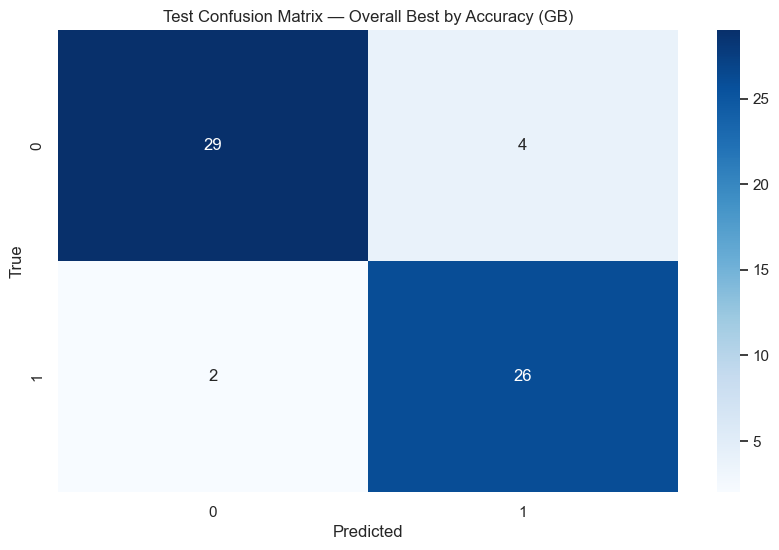

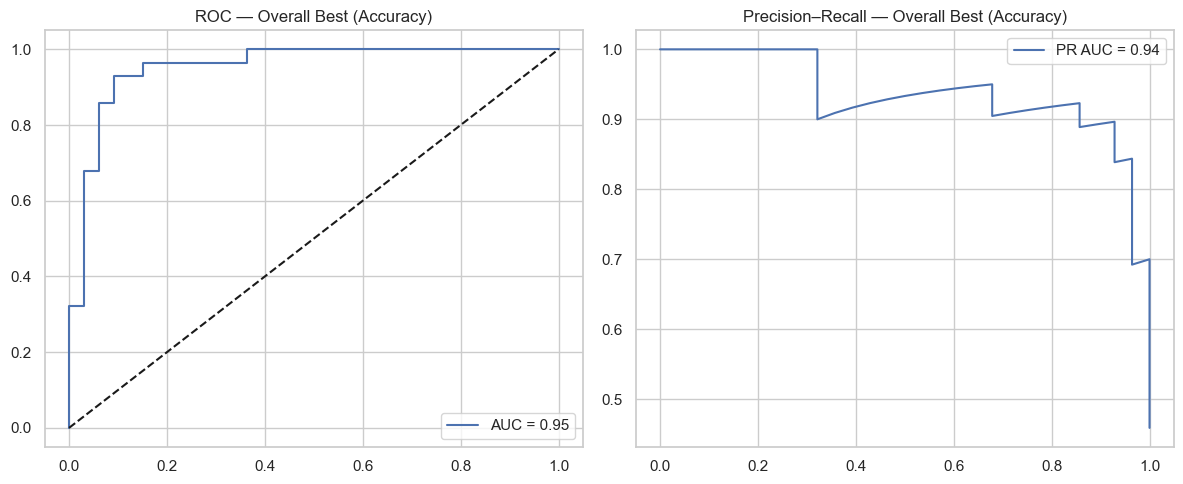

In [18]:
# ---- Confusion Matrix / ROC / PR for the overall best-by-accuracy ----
cm = confusion_matrix(y_test, best_test_res['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Test Confusion Matrix — Overall Best by Accuracy ({overall_best_name.upper()})')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_test_res['y_proba'])
roc_auc_val = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_test, best_test_res['y_proba'])
pr_auc_val = auc(rec, prec)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_val:.2f}')
plt.plot([0,1],[0,1],'k--'); plt.title('ROC — Overall Best (Accuracy)'); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f'PR AUC = {pr_auc_val:.2f}')
plt.title('Precision–Recall — Overall Best (Accuracy)'); plt.legend()
plt.tight_layout(); plt.show()

In [19]:
# ---- Comparison table sorted by TEST ACCURACY ----
print("\n" + "="*110)
print(f"MODEL COMPARISON TABLE (CV optimized for {OPTIMIZATION_METRIC.upper()}, ranked by TEST Accuracy)")
print("="*110)
print(f"{'Model':<10} {'Combo':<30} {'CV_' + OPTIMIZATION_METRIC.upper():<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC AUC':<10}")
print("-"*110)
for mname, info in ranked:  # already sorted by Accuracy desc
    metrics = info['test_metrics']
    combo_parts = info['combo'].split('-')
    combo_short = f"{combo_parts[0][:3]}-{combo_parts[1][:3]}-{combo_parts[2][:6]}"
    cv_score = info['cv_optimization_score']
    print(f"{mname.upper():<10} {combo_short:<30} {cv_score:<12.4f} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['roc_auc']:<10.4f}")
print("="*110)


MODEL COMPARISON TABLE (CV optimized for ROC_AUC, ranked by TEST Accuracy)
Model      Combo                          CV_ROC_AUC   Accuracy   Precision  Recall     F1         ROC AUC   
--------------------------------------------------------------------------------------------------------------
GB         bas-sta-kbest_                 0.9033       0.9016     0.8667     0.9286     0.8966     0.9535    
XGB        bas-sta-kbest_                 0.9002       0.9016     0.8667     0.9286     0.8966     0.9416    
LR         bas-min-rfe_sv                 0.9150       0.8852     0.8387     0.9286     0.8814     0.9567    
ENSEMBLE   bas-sta-kbest_                 0.9124       0.8852     0.8387     0.9286     0.8814     0.9535    
KNN        bas-sta-kbest_                 0.9185       0.8689     0.8125     0.9286     0.8667     0.9264    
RF         bas-sta-kbest_                 0.9073       0.8689     0.8125     0.9286     0.8667     0.9470    
LGBM       bas-rob-varian                 0

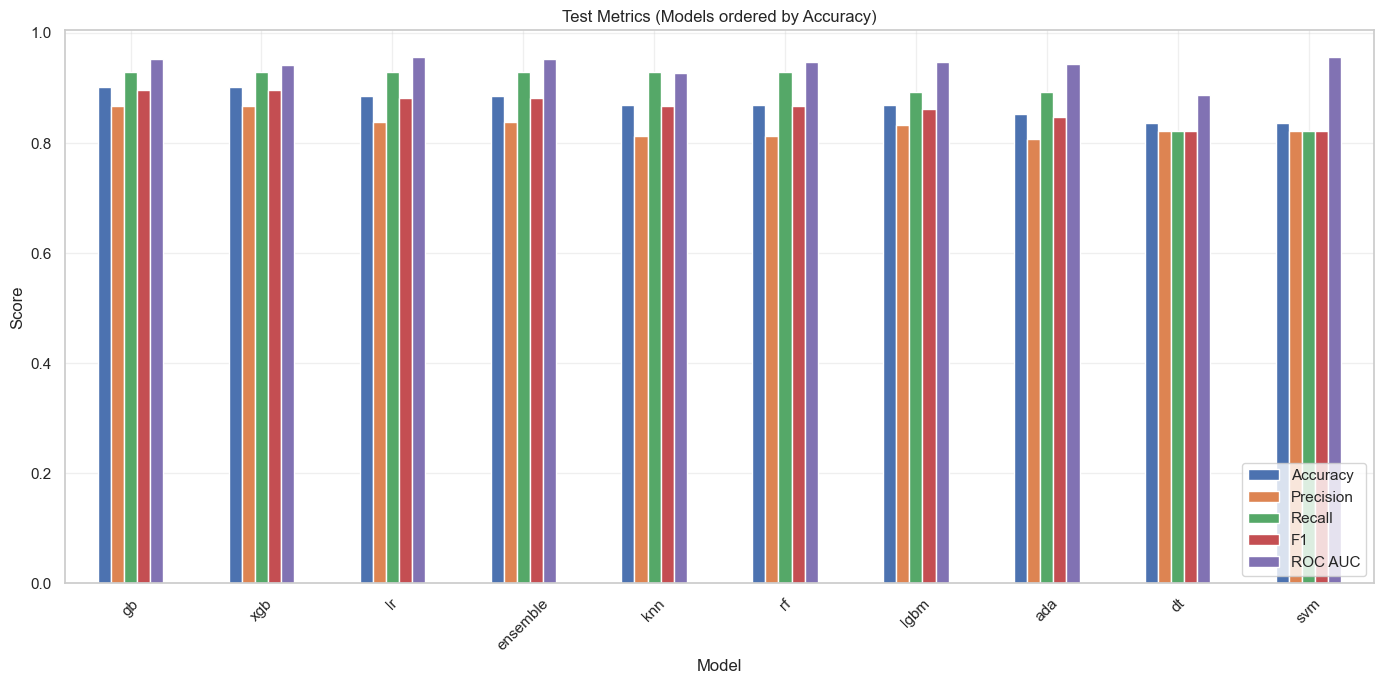

In [20]:
# ---- Bar chart of test metrics; order by TEST ACCURACY ----
metrics_df = pd.DataFrame({
    'Model':    [m for m, _ in ranked],
    'Accuracy': [info['test_metrics']['accuracy']  for _, info in ranked],
    'Precision':[info['test_metrics']['precision'] for _, info in ranked],
    'Recall':   [info['test_metrics']['recall']    for _, info in ranked],
    'F1':       [info['test_metrics']['f1']        for _, info in ranked],
    'ROC AUC':  [info['test_metrics']['roc_auc']   for _, info in ranked],
})
metrics_df.set_index('Model').plot(kind='bar', figsize=(14,7))
plt.title('Test Metrics (Models ordered by Accuracy)')
plt.ylabel('Score'); plt.xticks(rotation=45)
plt.legend(loc='lower right'); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

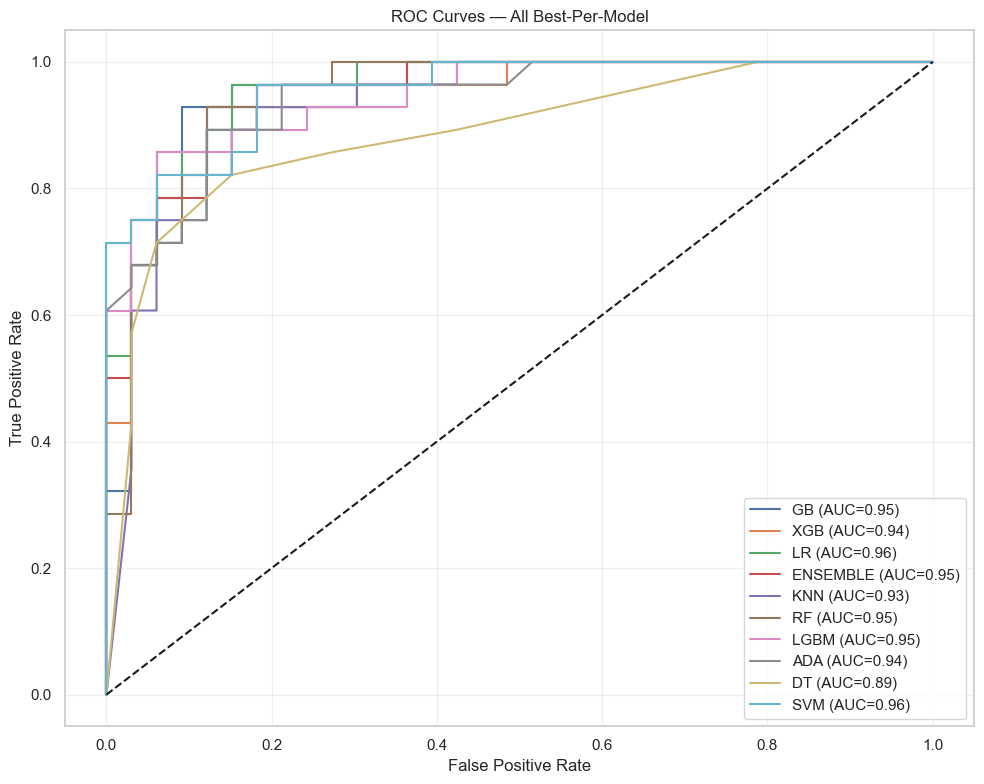

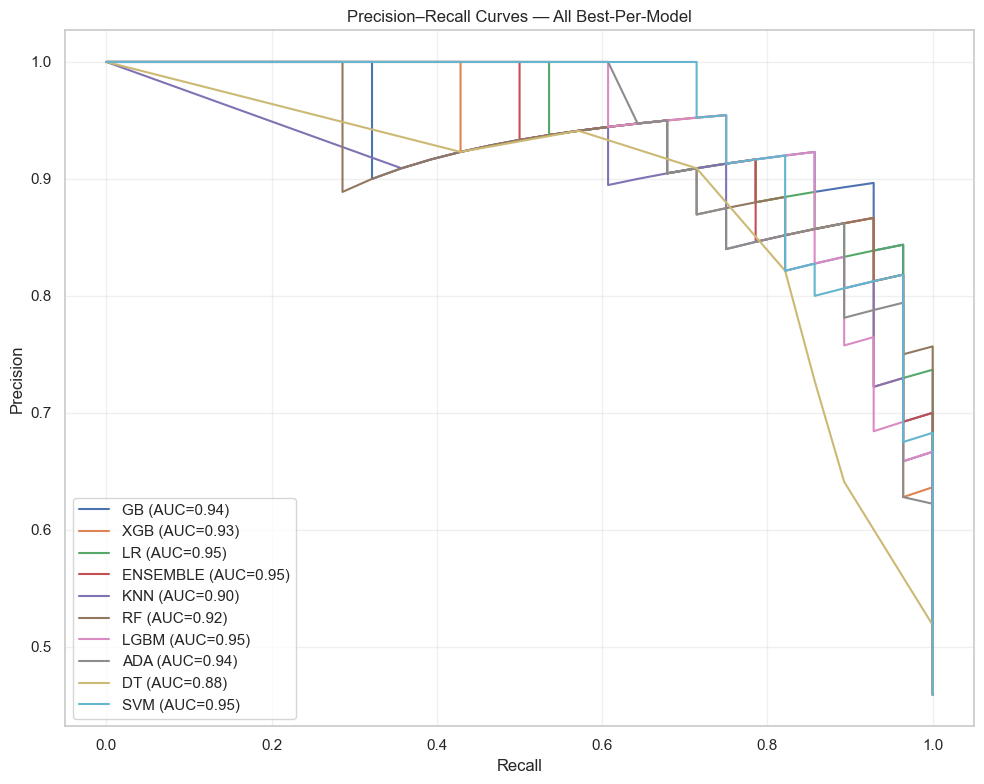

In [21]:
# ---- ROC/PR curves for all models ----
plt.figure(figsize=(10, 8))
for mname, res in ranked:
    if 'y_proba' in res:
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        plt.plot(fpr, tpr, label=f'{mname.upper()} (AUC={res["test_metrics"]["roc_auc"]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves — All Best-Per-Model'); plt.legend(loc='lower right')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 8))
for mname, res in ranked:
    if 'y_proba' in res:
        prec, rec, _ = precision_recall_curve(y_test, res['y_proba'])
        plt.plot(rec, prec, label=f'{mname.upper()} (AUC={auc(rec, prec):.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curves — All Best-Per-Model')
plt.legend(loc='lower left'); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


## SHAP

In [22]:
import os, json, uuid, warnings, pathlib, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Quiet warnings a bit (optional)
warnings.filterwarnings("ignore")

BASE_PACK_DIR = "packs"

def _ensure_dir(d):
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

def _timestamp():
    return time.strftime("%Y%m%d-%H%M%S")

def _short_id():
    return uuid.uuid4().hex[:8]


In [23]:
def build_design_matrices(best_models, model_key, 
                          X_train, y_train, X_test, y_test, 
                          bg_size=100, random_state=0):
    """
    Recreate the full preprocessing for the chosen best model (by key in best_models),
    train the model on TRAIN ONLY, and return FS-space matrices + predictions.
    """
    assert model_key in best_models, f"model_key '{model_key}' not in best_models keys: {list(best_models.keys())}"
    info = best_models[model_key]

    fe_transformer = info['fe_transformer']
    scaler_name    = info['scaler_name']
    fs_name        = info['fs_name']
    model_class    = info['model_class']
    best_params    = info['best_params'].copy()

    # Recreate final training kwargs
    extra_kwargs = {}
    if model_key in ['dt', 'rf', 'ada', 'gb', 'xgb', 'lgbm', 'lr']:
        extra_kwargs['random_state'] = 42
    if model_key == 'svm':
        extra_kwargs['probability'] = True
    if model_key == 'lgbm':
        extra_kwargs['verbose'] = -1
    if model_key == 'xgb':
        extra_kwargs['eval_metric'] = 'logloss'
    if model_key in ['rf', 'xgb', 'lgbm', 'knn', 'lr']:
        extra_kwargs['n_jobs'] = 1
    if 'max_iter' not in best_params and model_key == 'lr':
        best_params['max_iter'] = 300

    # 1) Impute + Feature engineering (fit on TRAIN only)
    pre_pipe = Pipeline([
        ('imputer', DFImputer()),
        ('fe', fe_transformer)
    ])
    X_train_fe = pre_pipe.fit_transform(X_train)
    X_test_fe  = pre_pipe.transform(X_test)
    num_fe = pre_pipe.named_steps['fe'].num_features
    cat_fe = pre_pipe.named_steps['fe'].cat_features

    # 2) Scale + OHE (fit on TRAIN only)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_options[scaler_name], num_fe),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_fe)
        ]
    )
    X_train_pre = preprocessor.fit_transform(X_train_fe)
    X_test_pre  = preprocessor.transform(X_test_fe)

    if hasattr(X_train_pre, 'toarray'):
        X_train_pre = X_train_pre.toarray()
    if hasattr(X_test_pre, 'toarray'):
        X_test_pre = X_test_pre.toarray()

    # Compose feature names at the preprocessed stage
    ohe_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_fe)
    all_features = np.concatenate([num_fe, ohe_names])

    # 3) Feature selection (fit on TRAIN only)
    X_train_fs, fs_idx = fs_options[fs_name](X_train_pre, y_train)
    X_test_fs = X_test_pre[:, fs_idx]
    selected_features = all_features[fs_idx]

    # 4) Fit final model on train_fs
    model = model_class(**best_params, **extra_kwargs)
    model.fit(X_train_fs, y_train)

    # 5) Predictions / metrics for sanity (accuracy)
    y_pred = model.predict(X_test_fs)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_fs)[:, 1]
    else:
        y_proba = y_pred.astype(float)
    acc = accuracy_score(y_test, y_pred)

    # 6) Background (SHAP): small sample of TRAIN_FS
    rng = np.random.RandomState(random_state)
    bg_n = min(bg_size, X_train_fs.shape[0])
    bg_idx = rng.choice(np.arange(X_train_fs.shape[0]), size=bg_n, replace=False)
    X_bg_fs = X_train_fs[bg_idx]

    # Convert to DataFrames with column names in FS space
    X_bg_df   = pd.DataFrame(X_bg_fs,   columns=selected_features)
    X_test_df = pd.DataFrame(X_test_fs, columns=selected_features)
    y_test_s  = pd.Series(y_test.values if hasattr(y_test, "values") else np.asarray(y_test), name="target")

    preds_df = pd.DataFrame({
        "y_true": y_test_s.values,
        "y_pred": y_pred,
        "y_proba": y_proba
    })

    return {
        "model": model,
        "pre_pipe": pre_pipe,
        "preprocessor": preprocessor,
        "fs_name": fs_name,
        "fs_idx": fs_idx,
        "selected_features": selected_features,
        "X_bg": X_bg_df,
        "X_test": X_test_df,
        "y_test": y_test_s,
        "preds_df": preds_df,
        "test_accuracy": acc,
        "meta": {
            "model": model_key,
            "dataset": "UCI_Heart_Cleveland",
            "imbalance": "none",
            "fe": info['combo'].split('-')[0],
            "scaler": scaler_name,
            "fs": fs_name,
            "cv_metric": OPTIMIZATION_METRIC,
            "cv_score": info['cv_optimization_score'],
        }
    }


In [24]:
# save a pack to disk (model + matrices + meta)

def save_shap_pack(pack_dict, out_dir=None):
    if out_dir is None:
        out_dir = os.path.join(BASE_PACK_DIR, f"{pack_dict['meta']['model']}_{_timestamp()}_{_short_id()}")
    _ensure_dir(out_dir)

    # paths
    paths = {
        "dir": out_dir,
        "model": os.path.join(out_dir, "model.joblib"),
        "X_background": os.path.join(out_dir, "X_bg.csv"),
        "X_test": os.path.join(out_dir, "X_test.csv"),
        "y_test": os.path.join(out_dir, "y_test.csv"),
        "predictions": os.path.join(out_dir, "preds.csv"),
        "meta": os.path.join(out_dir, "meta.json"),
    }

    # save artifacts
    dump(pack_dict["model"], paths["model"])
    pack_dict["X_bg"].to_csv(paths["X_background"], index=False)
    pack_dict["X_test"].to_csv(paths["X_test"], index=False)
    pack_dict["y_test"].to_csv(paths["y_test"], index=False)
    pack_dict["preds_df"].to_csv(paths["predictions"], index=False)

    meta = {
        "model": pack_dict["meta"]["model"],
        "dataset": pack_dict["meta"]["dataset"],
        "imbalance": pack_dict["meta"]["imbalance"],
        "cv_metric": pack_dict["meta"]["cv_metric"],
        "cv_score": pack_dict["meta"]["cv_score"],
        "feature_engineering": pack_dict["meta"]["fe"],
        "scaler": pack_dict["meta"]["scaler"],
        "feature_selection": pack_dict["meta"]["fs"],
        "paths": paths
    }
    with open(paths["meta"], "w") as f:
        json.dump(meta, f, indent=2)

    print(f"Saved SHAP pack → {out_dir}")
    return paths["meta"]


In [25]:
def pick_latest_global_best(base_dir=BASE_PACK_DIR):
    if not os.path.isdir(base_dir):
        return None
    metas = list(pathlib.Path(base_dir).glob("**/meta.json"))
    if not metas:
        return None
    latest = max(metas, key=lambda p: p.stat().st_mtime)
    return {"meta_path": str(latest)}

def load_pack(meta_path: str=None, fallback_to_latest_global=True):
    if meta_path is None and fallback_to_latest_global:
        cand = pick_latest_global_best()
        if cand is None:
            raise FileNotFoundError("No saved packs found. Run build_design_matrices() + save_shap_pack() first.")
        meta_path = cand["meta_path"]

    with open(meta_path, "r") as f:
        meta = json.load(f)

    model = load(meta["paths"]["model"])
    X_bg = pd.read_csv(meta["paths"]["X_background"])
    X_test = pd.read_csv(meta["paths"]["X_test"])
    y_test = pd.read_csv(meta["paths"]["y_test"])["target"]
    preds_path = meta["paths"].get("predictions")
    preds_df = pd.read_csv(preds_path) if preds_path and os.path.exists(preds_path) else None

    print(f"Loaded model: {meta['model']} | dataset={meta['dataset']} | imb={meta['imbalance']}")
    print(f"X_bg: {X_bg.shape} | X_test: {X_test.shape} | y_test: {y_test.shape}")
    return meta, model, X_bg, X_test, y_test, preds_df


In [26]:
import shap
from sklearn.linear_model import LogisticRegression

def build_shap_explainer(model, X_background: pd.DataFrame):
    name = type(model).__name__.lower()
    try:
        # Tree models
        if any(k in name for k in ["randomforest", "xgb", "lgbm", "gradientboosting", "adaboost", "extratrees"]):
            return shap.TreeExplainer(model)
        # Linear models
        if isinstance(model, LogisticRegression):
            try:
                return shap.LinearExplainer(model, X_background, feature_dependence="independent")
            except Exception:
                return shap.LinearExplainer(model, X_background)
        # SVM / KNN / other → KernelExplainer (use small background)
        bg = X_background.sample(n=min(200, len(X_background)), random_state=0)
        return shap.KernelExplainer(model.predict_proba, bg, link="logit")
    except Exception as e:
        warnings.warn(f"Falling back to KernelExplainer due to: {e}")
        bg = X_background.sample(n=min(200, len(X_background)), random_state=0)
        return shap.KernelExplainer(model.predict_proba, bg, link="logit")


In [27]:
# Build & save a pack for the best-by-accuracy model

# Pick overall best by test accuracy from best_models
_acc_ranked = sorted(best_models.items(), key=lambda kv: kv[1]['test_metrics']['accuracy'], reverse=True)
overall_best_key, overall_best_info = _acc_ranked[0]
print("Overall best (by test accuracy):", overall_best_key, " | acc =", overall_best_info['test_metrics']['accuracy'])

# Build matrices and model
pack = build_design_matrices(best_models, overall_best_key, X_train, y_train, X_test, y_test,
                             bg_size=100, random_state=0)

# Optionally overwrite 'model' in best_models with this re-trained final model
best_models[overall_best_key]['trained_model'] = pack['model']

# Save the pack
meta_path = save_shap_pack(pack, out_dir=None)  # set out_dir if you want a fixed folder
print("meta_path:", meta_path)


Overall best (by test accuracy): gb  | acc = 0.9016393442622951
Saved SHAP pack → packs/gb_20251013-200226_3fe14005
meta_path: packs/gb_20251013-200226_3fe14005/meta.json


In [28]:
# eload the saved pack (now or later)

meta, fitted_model, X_bg, X_test_fs, y_test_series, preds_df = load_pack(meta_path=None)  # or pass a specific meta.json path
print(preds_df.head())


Loaded model: gb | dataset=UCI_Heart_Cleveland | imb=none
X_bg: (100, 22) | X_test: (61, 22) | y_test: (61,)
   y_true  y_pred   y_proba
0       0       0  0.156309
1       0       0  0.357136
2       0       0  0.049876
3       0       0  0.063517
4       0       0  0.316618


Explainer: TreeExplainer


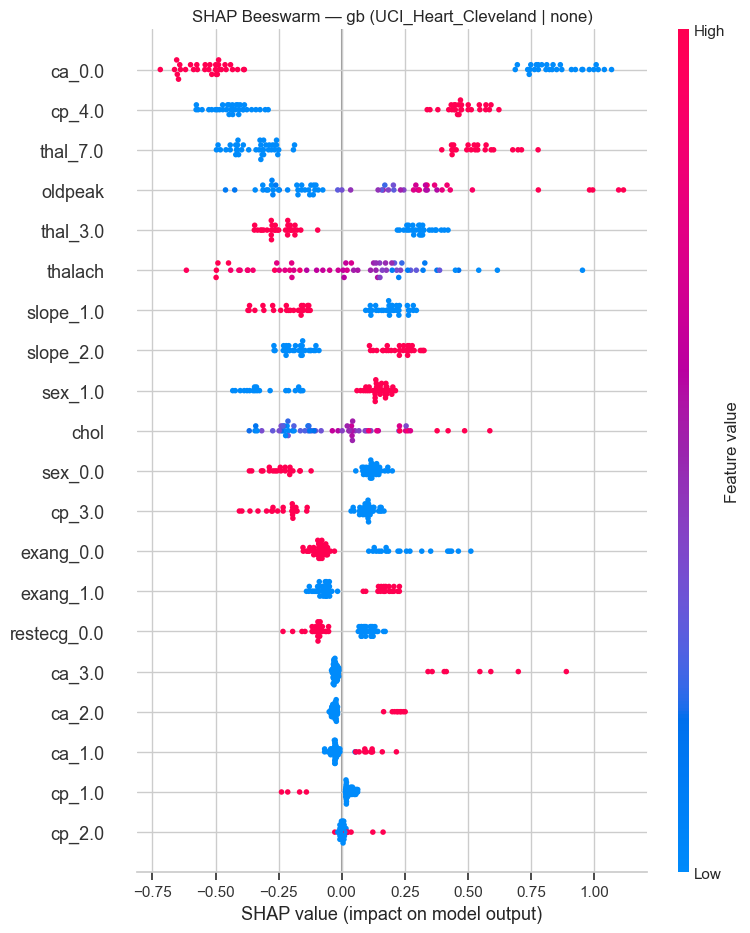

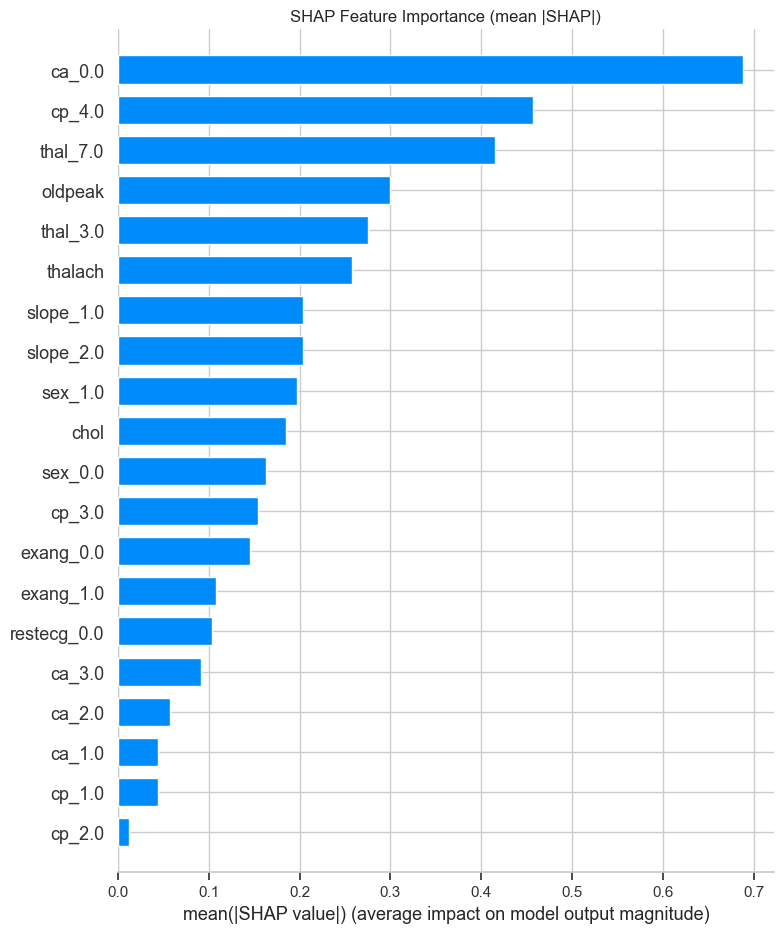

In [29]:
# SHAP summary plots (beeswarm + bar)

# Build explainer from the loaded model and background
explainer = build_shap_explainer(fitted_model, X_bg)
print("Explainer:", type(explainer).__name__)

# Compute SHAP values on a manageable slice for speed
X_slice = X_test_fs.iloc[:min(512, len(X_test_fs))].copy()

# shap_values can be list (multiclass) or array (binary)
sv = explainer.shap_values(X_slice)

def _pick_binary_class_shap(values):
    # For many sklearn/xgb/lgbm tree explainers on binary classification, values may be:
    # - list of length 2 (for each class) → take class 1
    # - a 2D array already (n_samples, n_features)
    if isinstance(values, list):
        if len(values) == 2:   # class 0, class 1
            return values[1]
        # some versions return [array] only → use first
        return values[0]
    return values

sv_bin = _pick_binary_class_shap(sv)

plt.figure(figsize=(9, 6))
shap.summary_plot(sv_bin, X_slice, show=False)
plt.title(f"SHAP Beeswarm — {meta['model']} ({meta['dataset']} | {meta['imbalance']})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 6))
shap.summary_plot(sv_bin, X_slice, plot_type="bar", show=False, max_display=20)
plt.title("SHAP Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()


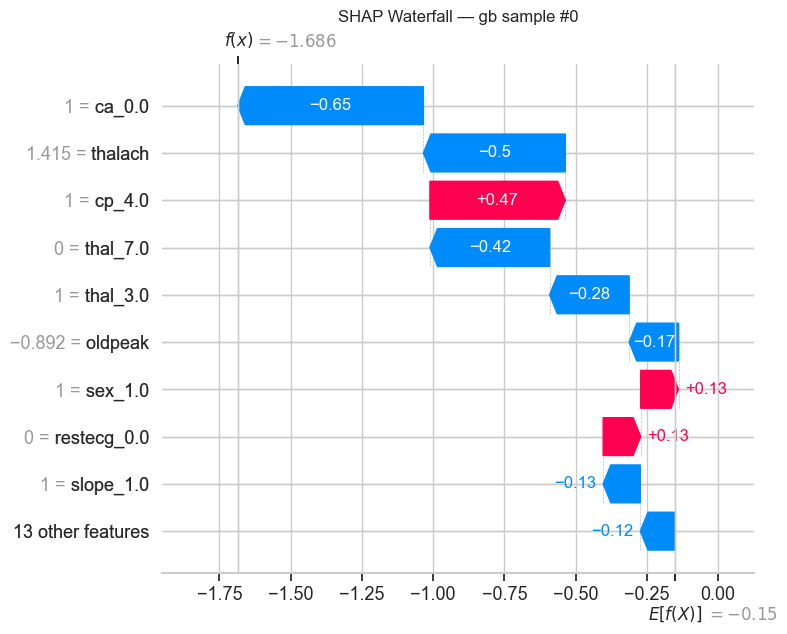

In [30]:
# waterfall plot (first sample)

try:
    base_val = explainer.expected_value
    # If list (per-class), take class 1 base value
    if isinstance(base_val, list) or isinstance(base_val, np.ndarray):
        if isinstance(base_val, list) and len(base_val) > 1:
            base_val = base_val[1]
        elif isinstance(base_val, np.ndarray) and base_val.shape and base_val.size > 1:
            base_val = base_val.flat[-1]

    idx = 0
    sv_row = sv_bin[idx]
    x_row = X_slice.iloc[idx]

    # Newer shap interface supports Explanation; fallback if older version
    try:
        exp = shap.Explanation(values=sv_row,
                               base_values=base_val,
                               data=x_row.values,
                               feature_names=list(X_slice.columns))
        shap.plots.waterfall(exp, show=False)
    except Exception:
        shap.waterfall_plot(shap.Explanation(values=sv_row,
                                             base_values=base_val,
                                             data=x_row.values,
                                             feature_names=list(X_slice.columns)), show=False)
    plt.title(f"SHAP Waterfall — {meta['model']} sample #{idx}")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Waterfall plot not available in this SHAP version:", e)


## Save Models with Complete Preprocessing Pipeline

Now we need to save the models with their complete preprocessing pipelines (pre_pipe, preprocessor, fs_indices) so they can be used for prediction without needing training data.

In [ ]:
# Save models with complete preprocessing pipeline for prediction
import joblib
from pathlib import Path

# Create output directory
output_dir = Path("../models/saved_models/latest")
output_dir.mkdir(parents=True, exist_ok=True)

# Model name mapping
model_name_map = {
    'lr': 'Logistic Regression',
    'rf': 'Random Forest', 
    'knn': 'K-Nearest Neighbors',
    'dt': 'Decision Tree',
    'ada': 'AdaBoost',
    'gb': 'Gradient Boosting',
    'xgb': 'XGBoost',
    'lgbm': 'LightGBM',
    'svm': 'SVM'
}

# For each best model, recreate the complete preprocessing pipeline and save
for model_key, model_info in best_models.items():
    print(f"\n📦 Saving {model_key.upper()} with complete pipeline...")
    
    # Get model components
    fe_transformer = model_info['fe_transformer']
    scaler_name = model_info['scaler_name']
    fs_name = model_info['fs_name']
    
    # Create pre_pipe (imputer + FE)
    pre_pipe = Pipeline([
        ('imputer', DFImputer()),
        ('fe', fe_transformer)
    ])
    
    # Fit pre_pipe on training data
    X_train_fe = pre_pipe.fit_transform(X_train)
    num_fe = pre_pipe.named_steps['fe'].num_features
    cat_fe = pre_pipe.named_steps['fe'].cat_features
    
    # Create and fit preprocessor (scaling + OHE)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_options[scaler_name], num_fe),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_fe)
        ]
    )
    X_train_pre = preprocessor.fit_transform(X_train_fe)
    
    # Convert to dense if sparse
    if hasattr(X_train_pre, 'toarray'):
        X_train_pre = X_train_pre.toarray()
    
    # Apply feature selection to get indices
    _, fs_indices = fs_options[fs_name](X_train_pre, y_train)
    
    # Extract feature names after preprocessing
    # Get numerical feature names (stay the same after scaling)
    num_names = list(num_fe)
    
    # Get categorical feature names after one-hot encoding
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_names = list(cat_transformer.get_feature_names_out(cat_fe))
    
    # Combine all feature names
    all_feature_names = num_names + cat_names
    
    # Apply feature selection to get final feature names
    selected_feature_names = [all_feature_names[i] for i in fs_indices]
    
    # Create complete pipeline dict
    pipeline_dict = {
        'model': model_info.get('trained_model'),  # The trained model
        'fe_transformer': fe_transformer,  # For FE (already fitted)
        'scaler_name': scaler_name,  # Scaler name for reference
        'preprocessor': preprocessor,  # Fitted preprocessor (scaling + OHE)
        'fs_name': fs_name,  # FS name for reference
        'fs_indices': fs_indices,  # Feature selection indices
        'feature_names': selected_feature_names,  # ⭐ Actual feature names after FS
        'numerical_features': num_fe,  # List of numerical features
        'categorical_features': cat_fe,  # List of categorical features
        'optimization_metric': model_info.get('optimization_metric', 'roc_auc'),
        'test_metrics': model_info.get('test_metrics', {})
    }
    
    # Save to file
    filename = f"best_{model_key}_model_pipeline.pkl"
    filepath = output_dir / filename
    joblib.dump(pipeline_dict, filepath)
    print(f"   ✅ Saved {filename}")
    print(f"      - Model: {type(pipeline_dict['model']).__name__}")
    print(f"      - FE: {type(fe_transformer).__name__}")
    print(f"      - Scaler: {scaler_name}")
    print(f"      - FS: {fs_name}")
    print(f"      - FS indices shape: {fs_indices.shape}")
    print(f"      - Final features: {len(fs_indices)}")
    print(f"      - Feature names: {selected_feature_names[:5]}...")  # Show first 5

print(f"\n✅ All models saved to {output_dir}")
print(f"📝 Models can now be used for prediction with complete preprocessing!")


📦 Saving DT with complete pipeline...
   ✅ Saved best_dt_model_pipeline.pkl
      - Model: DecisionTreeClassifier
      - FE: PolyFE
      - Scaler: robust
      - FS: boruta
      - FS indices shape: (7,)
      - Final features: 7
      - Feature names: ['thalach', 'chol oldpeak', 'thalach^2', 'cp_4.0', 'ca_0.0']...

📦 Saving KNN with complete pipeline...
   ✅ Saved best_knn_model_pipeline.pkl
      - Model: KNeighborsClassifier
      - FE: BasicFE
      - Scaler: standard
      - FS: kbest_mi
      - FS indices shape: (22,)
      - Final features: 22
      - Feature names: ['age', 'chol', 'thalach', 'oldpeak', 'sex_0.0']...

📦 Saving RF with complete pipeline...
   ✅ Saved best_rf_model_pipeline.pkl
      - Model: RandomForestClassifier
      - FE: BasicFE
      - Scaler: standard
      - FS: kbest_mi
      - FS indices shape: (22,)
      - Final features: 22
      - Feature names: ['age', 'chol', 'thalach', 'oldpeak', 'sex_0.0']...

📦 Saving ADA with complete pipeline...
   ✅ Saved